# How to use this notebook

This notebook creates an augmented dataset and use it to train and finetune CovNextBase.

To use it run the cells under:
- libraries
- drive mount (mount your drive)
- utilities
- load dataset (load the dataset, split train and validation, balance classes)
- augmentation pipeline (DO NOT RUN AUGMENTATION TESTING) (funcions used to augment the dataset)
- define your array of augmentation in a dedicated section (see Test Augmentation 1)
- run create augmented dataset
- run train classifier

# Libraries

## TensorFlow and Keras

In [ ]:
!pip install tensorflow==2.17.0 keras==3.4.1 keras-cv

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
import keras_cv as tfkcv
from keras_cv import layers as tfkcvl

print(tf.__version__)
print(tfk.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 46.5 MB/s eta 0:00:00
2.17.0
3.4.1


## Others

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Università/ANN/'
import random

# Generate a random number to use as the seed
SEED = random.randint(0, 2**32 - 1)  # Generates a random integer within the range of 32-bit seeds
print("Generated Seed:", SEED)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utilities

In [ ]:
def visualize_dataset(dataset, num_samples=9):
    # Take a batch of augmented images and labels from the dataset
    image_batch, label_batch = next(iter(dataset.batch(num_samples))) # Batch size of 9 for visualization

    # Display 9 images from the batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert image to uint8 for display
        # Convert label from the one hot encoded array to a float
        label = np.argmax(label_batch[i])
        plt.title(f"Label: {label}")
        plt.axis("off")

    plt.show()

In [ ]:
def print_dataset_charateristics(dataset):
  # Print len and element shape of the datasets
  print(f'Dataset size: {len(dataset)}')

  print(f'Dataset element shape: {next(iter(dataset))[0].shape}')

  print(f'Dataset element label: {next(iter(dataset))[1].shape}')

In [ ]:
def save_dataset(dataset, path):
  # Save the dataset
  tf.data.Dataset.save(augmented_dataset, path)
  # Copy the dataset in the correct drive folder
  import os
  import shutil

  source_path = path
  destination_path = DRIVE_PROJECT_PATH + path

  # Check if the destination path already exists
  if not os.path.exists(destination_path):
      # Create the destination directory
      os.makedirs(destination_path)
      print(f"Directory '{destination_path}' created.")
  else:
      print(f"Directory '{destination_path}' already exists.")

  # Copy the files from the source path to the destination path
  for filename in os.listdir(source_path):
      source_file = os.path.join(source_path, filename)
      destination_file = os.path.join(destination_path, filename)
      shutil.copy(source_file, destination_file)

# Load dataset

In [ ]:
from sklearn.utils import resample
from collections import Counter

def balance_data_oversample(images, labels):
    # Count the samples per class and determine the maximum class count
    # Convert labels to a 1D array to make it hashable
    labels = labels.ravel()  # Flatten the labels array
    class_counts = Counter(labels)
    max_count = max(class_counts.values())

    # Separate images and labels by class
    balanced_images = []
    balanced_labels = []

    for label in np.unique(labels):
        images_class = images[labels == label]

        # Oversample to match the maximum class count
        images_balanced = resample(images_class, replace=True, n_samples=max_count, random_state=0)

        # Collect balanced data
        balanced_images.append(images_balanced)
        balanced_labels.append([label] * len(images_balanced))

    # Concatenate all balanced classes
    balanced_images = np.vstack(balanced_images)
    balanced_labels = np.concatenate(balanced_labels)

    print(f"Balanced dataset size: {balanced_images.shape[0]}")
    print(f"Class distribution after balancing: {Counter(balanced_labels)}")

    return balanced_images, balanced_labels

In [ ]:
# Import data
def load_data():
    data = np.load(DRIVE_PROJECT_PATH + 'training_set.npz')

    images = data['images']
    labels = data['labels']

    # Convert values in data to int
    images = images.astype(int)

    rick = 13571
    wtf = 11962

    rick  = np.array([np.array_equal(i, images[rick]) for i in images])
    wtf = np.array([np.array_equal(i, images[wtf]) for i in images])

    # Finding label to remove
    to_remove = wtf + rick

    print(f"Size before removing outliers: {images.shape[0]}")

    # Removing outliers
    to_keep = ~ to_remove

    images_cleaned = images[to_keep]
    labels_cleaned = labels[to_keep]

    print(f"Size after removing outliers: {images_cleaned.shape[0]}")

    # Remove doubles
    unique_images, idx_unique = np.unique(images_cleaned, return_index= True, axis=0)

    print(f"Size before removing doubles: {images_cleaned.shape[0]}")

    labels_cleaned = labels_cleaned[idx_unique]
    images_cleaned = images_cleaned[idx_unique]
    count = len(images_cleaned)
    labels_unique = np.unique(labels_cleaned)


    print(labels_unique)
    print(f"Size after removing doubles: {count}")

    return images_cleaned, labels_cleaned

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Load dataset
images, labels = load_data()

# create a tensor slices dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

print_dataset_charateristics(dataset)

# visualize dataset info
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Dataset size: {len(dataset)}')

# visualize_dataset(dataset)

Size before removing outliers: 13759
Size after removing outliers: 11959
Size before removing doubles: 11959
[0 1 2 3 4 5 6 7]
Size after removing doubles: 11951
Dataset size: 11951
Dataset element shape: (96, 96, 3)
Dataset element label: (1,)
Images shape: (11951, 96, 96, 3)
Labels shape: (11951, 1)
Dataset size: 11951


In [ ]:
# print range of pixel values
print(f'Min pixel value: {np.min(images)}')
print(f'Max pixel value: {np.max(images)}')

Min pixel value: 0
Max pixel value: 255


## Train Validation split and class rebalancing through oversampling

In [ ]:
# Split the dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(images, labels, random_state=SEED,
                                                  test_size=0.2, stratify=np.argmax(labels,axis=1),
                                                  shuffle=True)         # Remember to shuffle!


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (9560, 96, 96, 3), y_train shape: (9560, 1)
X_val shape: (2391, 96, 96, 3), y_val shape: (2391, 1)


In [ ]:
X_train, y_train = balance_data_oversample(X_train, y_train)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Balanced dataset size: 14848
Class distribution after balancing: Counter({0: 1856, 1: 1856, 2: 1856, 3: 1856, 4: 1856, 5: 1856, 6: 1856, 7: 1856})
X_train shape: (14848, 96, 96, 3), y_train shape: (14848,)
X_val shape: (2391, 96, 96, 3), y_val shape: (2391, 1)


In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(labels):
  # one-hot encoding labeling
  label_encoder = LabelEncoder()
  # This converts to a vector of 0s and 1s
  labels_enc = label_encoder.fit_transform(labels)
  # This creates the one-hot encoding
  return tfk.utils.to_categorical(labels_enc)

In [ ]:
y_train = encode_labels(y_train)
y_val = encode_labels(y_val)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (14848, 96, 96, 3), y_train shape: (14848, 8)
X_val shape: (2391, 96, 96, 3), y_val shape: (2391, 8)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Shuffle training dataset
training_dataset = training_dataset.shuffle(buffer_size=len(training_dataset), seed=SEED)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
del images
del labels

del X_train
del y_train

# No need to del those!!! we need to keep the validation set!
# del X_val
# del y_val

In [ ]:
print_dataset_charateristics(training_dataset)

Dataset size: 14848
Dataset element shape: (96, 96, 3)
Dataset element label: (8,)


In [ ]:
print_dataset_charateristics(validation_dataset)

Dataset size: 2391
Dataset element shape: (96, 96, 3)
Dataset element label: (8,)


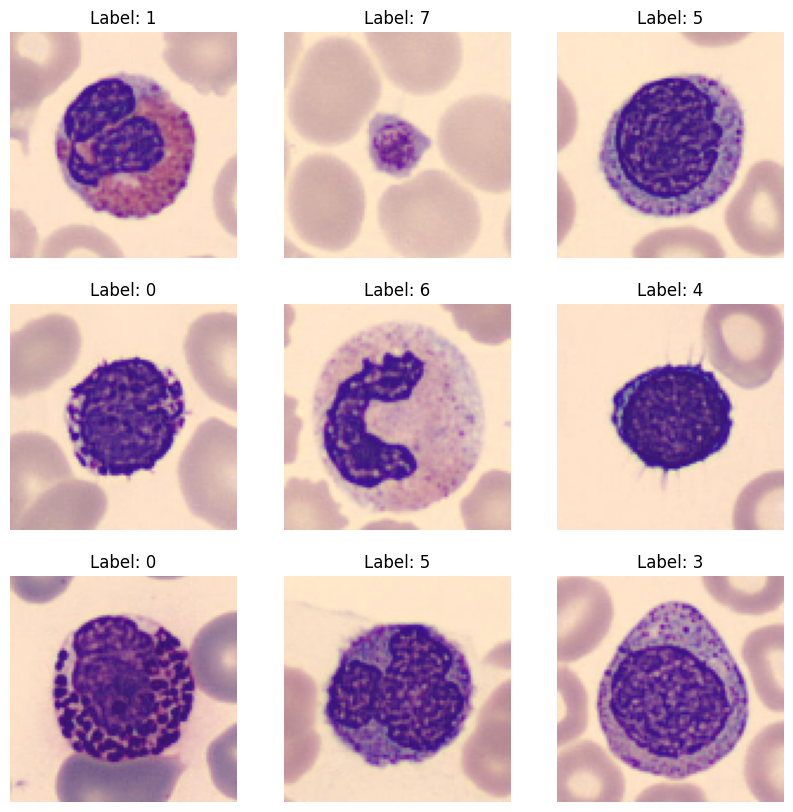

In [ ]:
# Visualize one image - label pair for training and validation
visualize_dataset(training_dataset)

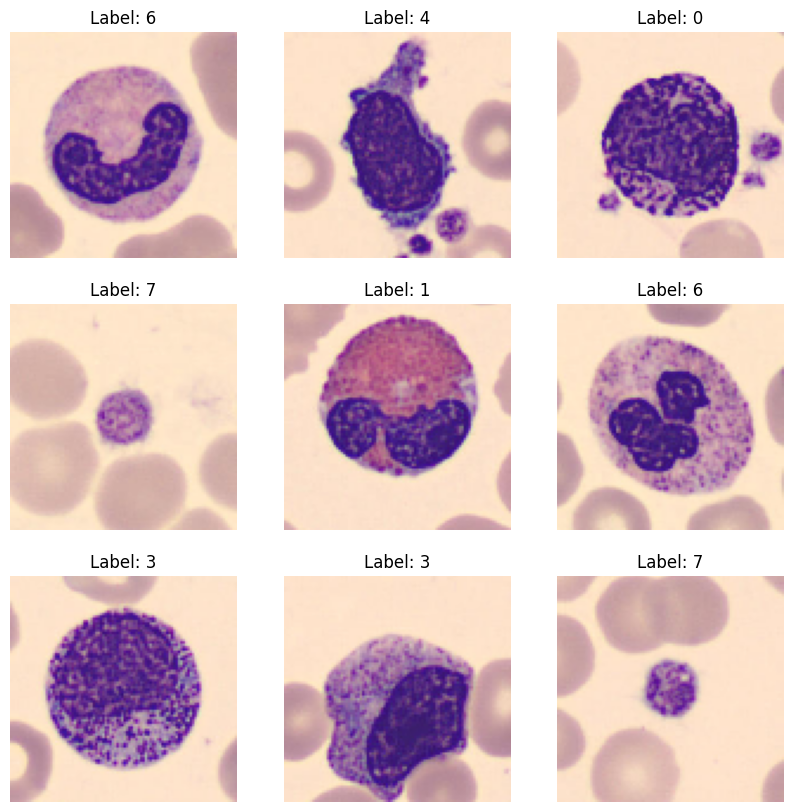

In [ ]:
visualize_dataset(validation_dataset)

# Augmentation testing

## Test CutMix

In [ ]:
cutMixLayer = tfkcvl.CutMix()

def applyCutMixAndMixUp(images, labels): # modified to accept two arguments: image and label
  # create a dictionary with the image and label
  data = {'images': images, 'labels': labels}
  # cast labels to float32
  data['labels'] = tf.cast(data['labels'], tf.float32)
  data = cutMixLayer(data, training=True)
  # return the modified image and label
  return data['images'], data['labels']

In [ ]:
cutMixDataset = dataset.batch(BATCH_SIZE).map(applyCutMixAndMixUp, num_parallel_calls=AUTOTUNE)

In [ ]:
# extract the images from the batches to obtain a full dataset
cutMixDataset = cutMixDataset.unbatch()

In [ ]:
print_dataset_charateristics(cutMixDataset)

TypeError: The dataset length is unknown.

<ipython-input-5-9b7cbaca40d3>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(label_batch[i].numpy()))  # Display label as title


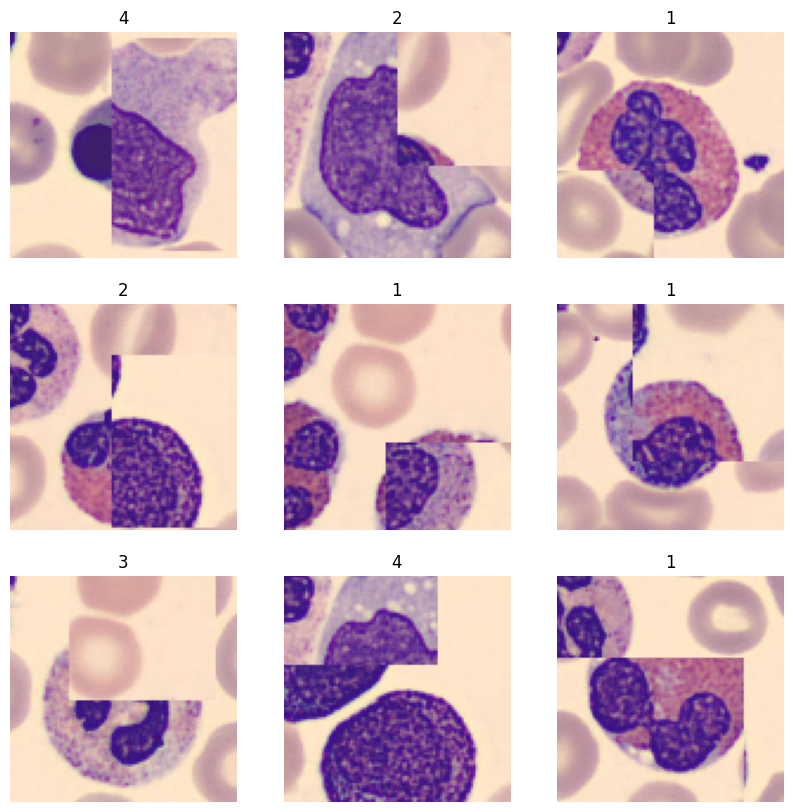

In [ ]:
visualize_dataset(cutMixDataset)

In [ ]:
del cutMixDataset
del cutMixLayer

## Test MixUp

In [ ]:
mixUpLayer = tfkcvl.MixUp(alpha=0.2)  # alpha is the mixup ratio can be higher, like 0.4

def applyCutMixAndMixUp(images, labels): # modified to accept two arguments: image and label
  # create a dictionary with the image and label
  data = {'images': images, 'labels': labels}
  # cast labels to float32
  data['labels'] = tf.cast(data['labels'], tf.float32)
  data = mixUpLayer(data, training=True) # typo fixed: training instead of trainint
  # return the modified image and label
  return data['images'], data['labels']

In [ ]:
mixUpDataset = dataset.batch(BATCH_SIZE).map(applyCutMixAndMixUp, num_parallel_calls=AUTOTUNE)

In [ ]:
# extract the images from the batches to obtain a full dataset
mixUpDataset = mixUpDataset.unbatch()

<ipython-input-6-9b7cbaca40d3>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(label_batch[i].numpy()))  # Display label as title


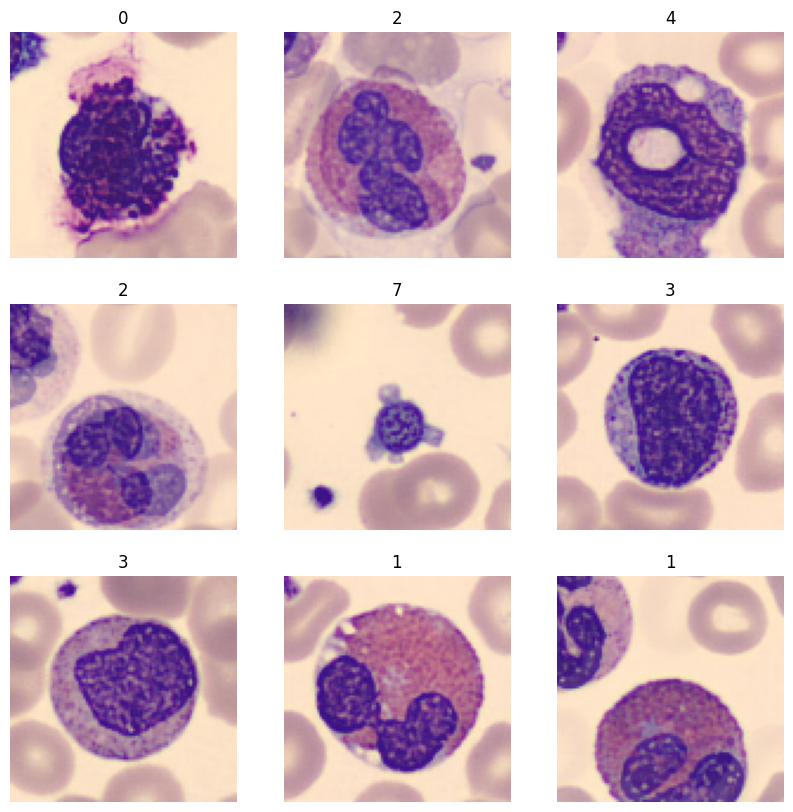

In [ ]:
visualize_dataset(mixUpDataset)

## Test RandAugment

In [ ]:
randAugmentLayer = tfkcvl.RandAugment(value_range=[0, 255])

def applyRandAugment(images, labels):
  return randAugmentLayer(images, training=True), labels

In [ ]:
# visualize layers of rangAugmentLayer
randAugmentLayer.layers

[<AutoContrast name=auto_contrast, built=True>,
 <Equalization name=equalization, built=True>,
 <Solarization name=solarization, built=True>,
 <RandomColorDegeneration name=random_color_degeneration, built=True>,
 <RandomContrast name=random_contrast, built=True>,
 <RandomBrightness name=random_brightness, built=True>,
 <RandomShear name=random_shear, built=True>,
 <RandomShear name=random_shear_1, built=True>,
 <RandomTranslation name=random_translation, built=True>,
 <RandomTranslation name=random_translation_1, built=True>]

In [ ]:
randAugmentedDataset = dataset.map(applyRandAugment, num_parallel_calls=AUTOTUNE)

<ipython-input-56-9b7cbaca40d3>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(label_batch[i].numpy()))  # Display label as title


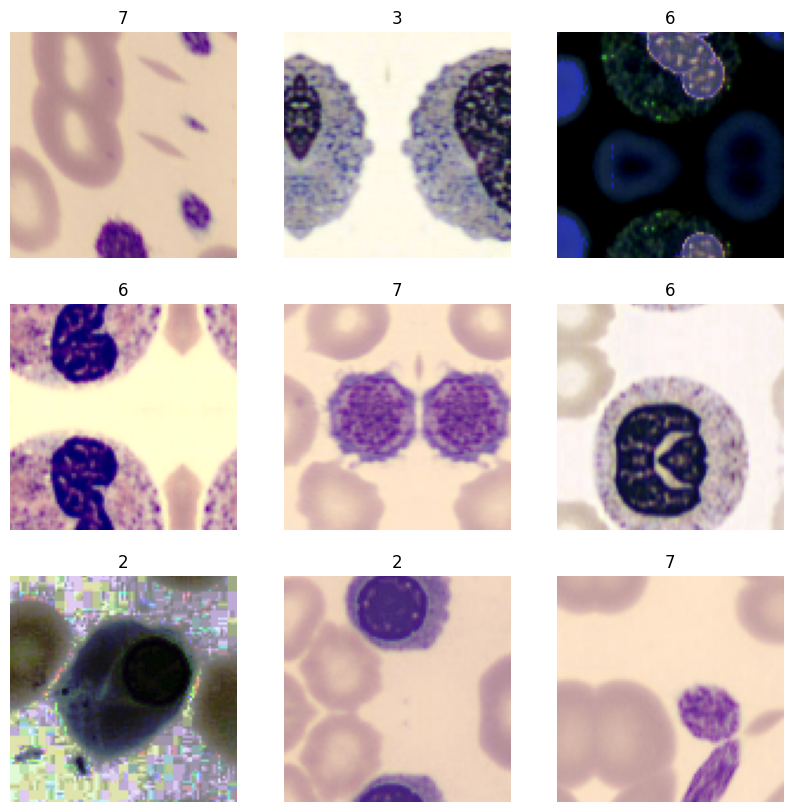

In [ ]:
visualize_dataset(randAugmentedDataset)

## Test Jittered

In [ ]:
jitteredLayer = tfkcvl.JitteredResize((96,96),(0.8, 1.25),(96,96),"xywh","bilinear")

def applyJittered(images, labels):
  return jitteredLayer(images, training=True), labels

In [ ]:
jitteredDataset = dataset.map(applyJittered, num_parallel_calls=AUTOTUNE)

In [ ]:
print(len(jitteredDataset))

11951


In [ ]:
print(len(dataset))

11951


<ipython-input-56-9b7cbaca40d3>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(label_batch[i].numpy()))  # Display label as title


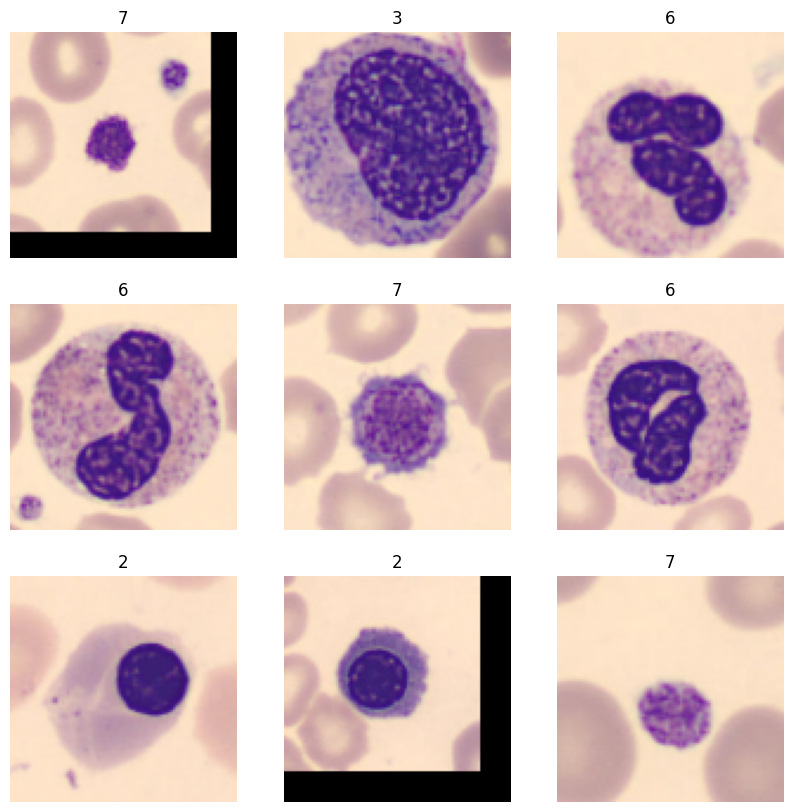

In [ ]:
visualize_dataset(jitteredDataset)

## Test GaussianNoise

In [ ]:
gaussianNoiseLayer = tfkl.GaussianNoise(1)

def applyGaussianNoise(images, labels):
  # cast images to float32
  images = tf.cast(images, tf.float32)
  return gaussianNoiseLayer(images, training=True), labels

In [ ]:
gaussianNoiseDataset = dataset.map(applyGaussianNoise, num_parallel_calls=AUTOTUNE)

<ipython-input-56-9b7cbaca40d3>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(label_batch[i].numpy()))  # Display label as title


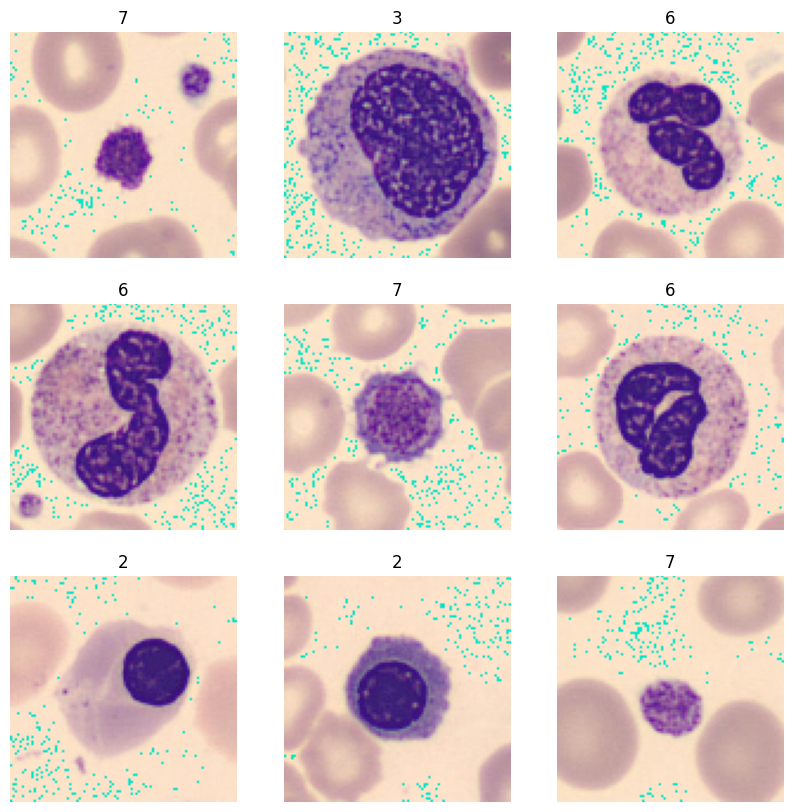

In [ ]:
visualize_dataset(gaussianNoiseDataset)

## Test Channel shuffle

In [ ]:
channelShuffleLayer = tfkcvl.ChannelShuffle()

def applyChannelShuffle(images, labels):
  return channelShuffleLayer(images, training=True), labels

In [ ]:
channelShuffleDataset = dataset.map(applyChannelShuffle, num_parallel_calls=AUTOTUNE)

<ipython-input-56-9b7cbaca40d3>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(label_batch[i].numpy()))  # Display label as title


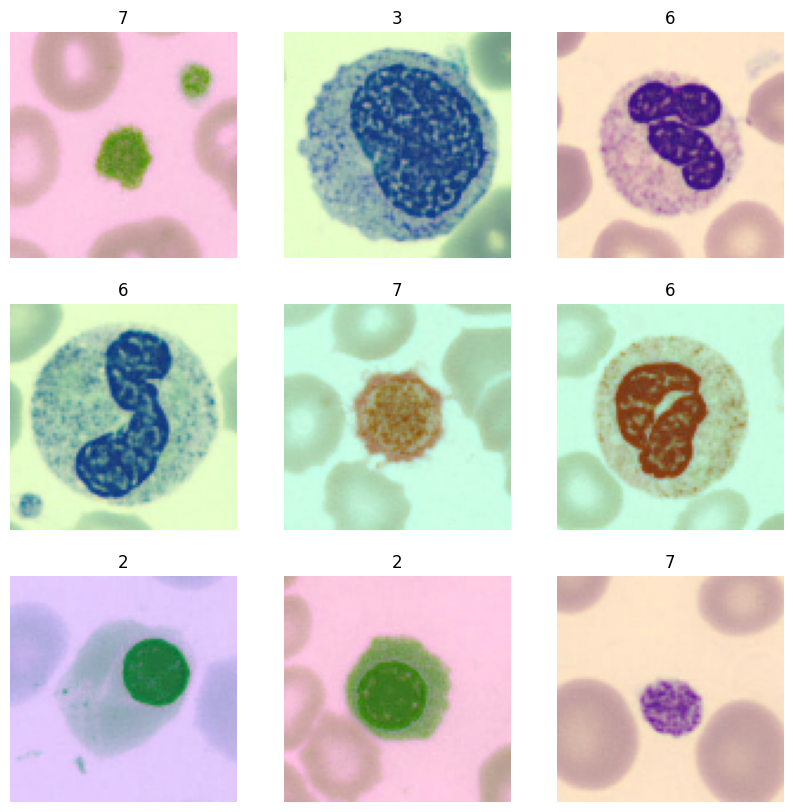

In [ ]:
visualize_dataset(channelShuffleDataset)

## Test GridMask

In [ ]:
gridMaskLayer = tfkcvl.GridMask()

def applyGridMask(images, labels):
  return gridMaskLayer(images, training=True), labels

In [ ]:
gridMaskDataset = dataset.map(applyGridMask, num_parallel_calls=AUTOTUNE)

<ipython-input-6-9b7cbaca40d3>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(label_batch[i].numpy()))  # Display label as title


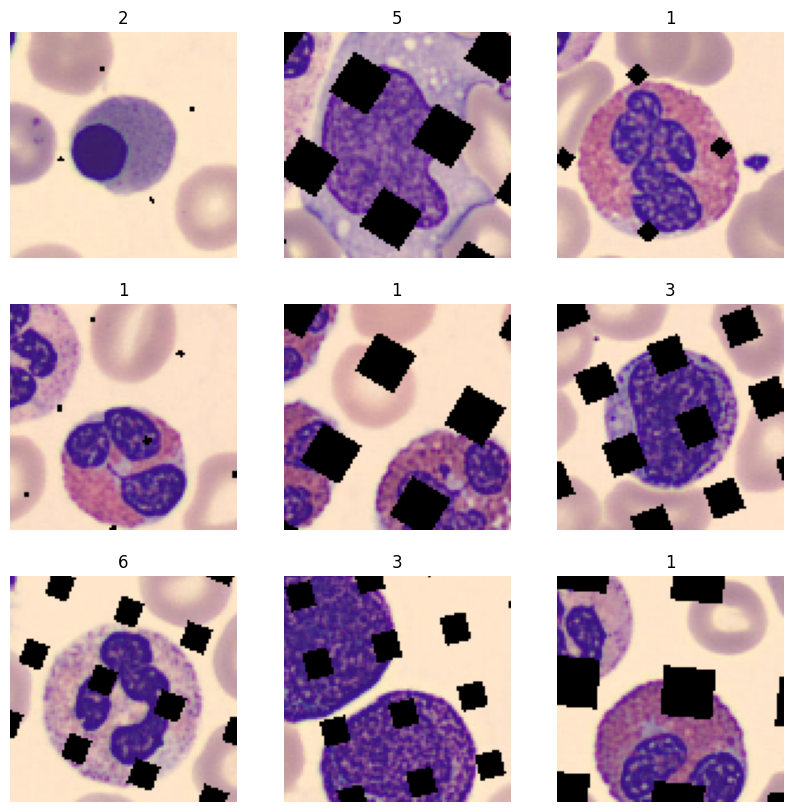

In [ ]:
visualize_dataset(gridMaskDataset)

# Augmentation pipeline

## Augmentation layers and functions

In [ ]:
# Possible augmentation steps

# CUTMIX
cutMixLayer = tfkcvl.CutMix()

def applyCutMix(images, labels): # modified to accept two arguments: image and label
  # create a dictionary with the image and label
  data = {'images': images, 'labels': labels}
  # cast labels to float32
  data['labels'] = tf.cast(data['labels'], tf.float32)
  data = cutMixLayer(data, training=True)
  # return the modified image and label
  return data['images'], data['labels']

# MIXUP
mixUpLayer = tfkcvl.MixUp(alpha=0.4)  # alpha is the mixup ratio can be higher, like 0.4

def applyMixUp(images, labels): # modified to accept two arguments: image and label
  # create a dictionary with the image and label
  data = {'images': images, 'labels': labels}
  # cast labels to float32
  data['labels'] = tf.cast(data['labels'], tf.float32)
  data = mixUpLayer(data, training=True) # typo fixed: training instead of trainint
  # return the modified image and label
  return data['images'], data['labels']

# RANDAUGMENT
randAugmentLayer = tfkcvl.RandAugment(value_range=[0, 255])

def applyRandAugment(images, labels):
  return randAugmentLayer(images, training=True), labels

# JITTERED
jitteredLayer = tfkcvl.JitteredResize((96,96),(0.8, 1.25),(96,96),"xywh","bilinear")

def applyJittered(images, labels):
  return jitteredLayer(images, training=True), labels

# GAUSSIAN NOISE
gaussianNoiseLayer = tfkl.GaussianNoise(1)

def applyGaussianNoise(images, labels):
  # cast images to float32
  images = tf.cast(images, tf.float32)
  return gaussianNoiseLayer(images, training=True), labels

# CHANNEL SHUFFLE
channelShuffleLayer = tfkcvl.ChannelShuffle()

def applyChannelShuffle(images, labels):
  return channelShuffleLayer(images, training=True), labels

# GRIDMASK
gridMaskLayer = tfkcvl.GridMask()

def applyGridMask(images, labels):
  return gridMaskLayer(images, training=True), labels

## Augmentation dictionary

In [ ]:
# AUGMENTATIONS DICTIONARY
augmentation_steps = {
    'cutmix': {
        'apply': applyCutMix,
        'need_batch': True
    },
    'mixup': {
        'apply': applyMixUp,
        'need_batch': True
    },
    'randaugment': {
        'apply': applyRandAugment,
        'need_batch': False
    },
    'jittered': {
        'apply': applyJittered,
        'need_batch': False
    },
    'gaussiannoise': {
        'apply': applyGaussianNoise,
        'need_batch': False
    },
    'channelshuffle': {
        'apply': applyChannelShuffle,
        'need_batch': False
    },
    'gridmask': {
        'apply': applyGridMask,
        'need_batch': False
    }
}

## Augmented dataset creation functions


In [ ]:
# Function that given the training set and a list of augmentation names apply sequentially the requested augmentations
def create_augmented_dataset(data, augmentations):
  augmented_dataset = data

  # Check if augmentations contains both gaussian noise and random augment, if so perform random augment first, the other way around it doesn't work
  if ('gaussiannoise' in augmentations) and ('randaugment' in augmentations):
    gaussian_noise_index = augmentations.index('gaussiannoise')
    rand_augment_index = augmentations.index('randaugment')
    if rand_augment_index > gaussian_noise_index:
      augmentations[gaussian_noise_index], augmentations[rand_augment_index] = augmentations[rand_augment_index], augmentations[gaussian_noise_index]

  print(f"Original Dataset Lenght = {len(augmented_dataset)}")

  for augmentation in augmentations:
    if augmentation_steps[augmentation]['need_batch']:
      augmented_dataset = augmented_dataset.batch(BATCH_SIZE).map(augmentation_steps[augmentation]['apply'], num_parallel_calls=AUTOTUNE)
      augmented_dataset = augmented_dataset.unbatch()
    else:
      augmented_dataset = augmented_dataset.map(augmentation_steps[augmentation]['apply'], num_parallel_calls=AUTOTUNE)

  dataset_length = 0
  for _ in augmented_dataset:
    dataset_length += 1

  print(f"Augmented Dataset Lenght = {dataset_length}")

  augmented_dataset = augmented_dataset.apply(tf.data.experimental.assert_cardinality(dataset_length))

  return augmented_dataset

In [ ]:
# Function to cast the dataset value to float before merging
def cast_to_float(images, labels):
  images = tf.cast(images, tf.float32)
  labels = tf.cast(labels, tf.float32)
  return images, labels

# Function that given the training set, a list of augmentation names and the size increase process the
#  dataset size increase times, each time applying a random number of the provided augmentation and
#  merge all the results in a single dataset
def create_augmented_dataset_increase_size(data, augmentations, increase_size):
  augmented_dataset = data.map(cast_to_float, num_parallel_calls=AUTOTUNE)

  print(f"Original Dataset Lenght = {len(augmented_dataset)}")

  for _ in range(increase_size):
    # Randomly select a number of augmentations to apply between 2 and the total number of augmentations -1
    num_augmentations = np.random.randint(2, len(augmentations) + 1 -1)        # What about never applying all of them?  more diversity!
    selected_augmentations = np.random.choice(augmentations, num_augmentations, replace=False)
    print(f"Selected augmentations: {selected_augmentations}")
    # Merge the new dataset with the original one
    augmented_dataset = augmented_dataset.concatenate(create_augmented_dataset(data, selected_augmentations).map(cast_to_float, num_parallel_calls=AUTOTUNE))

  dataset_length = 0
  for _ in augmented_dataset:
    dataset_length += 1

  print(f"Augmented Dataset Lenght = {dataset_length}")

  augmented_dataset = augmented_dataset.apply(tf.data.experimental.assert_cardinality(dataset_length))

  #TODO: add a shuffle here

  return augmented_dataset

# Test augmentation 1 - MixUp, CutMix, RandAugment

In [ ]:
augmentations = ['mixup', 'cutmix', 'randaugment', 'jittered', 'gridmask']

# Test augmentation 2 - ALL

In [ ]:
augmentations = list(augmentation_steps.keys())

# Create augmented dataset NO SIZE INCREASE

In [ ]:
print(len(training_dataset))

test = training_dataset.concatenate(training_dataset)

print(len(test))

14848
29696


In [ ]:
augmented_dataset = create_augmented_dataset(training_dataset, augmentations)

Original Dataset Lenght = 14848
Augmented Dataset Lenght = 14848


In [ ]:
print(len(augmented_dataset))

14848


In [ ]:
print(f'Dataset element shape: {next(iter(augmented_dataset))[0].shape}')

print(f'Dataset element label: {next(iter(augmented_dataset))[1].shape}')

Dataset element shape: (96, 96, 3)
Dataset element label: (8,)


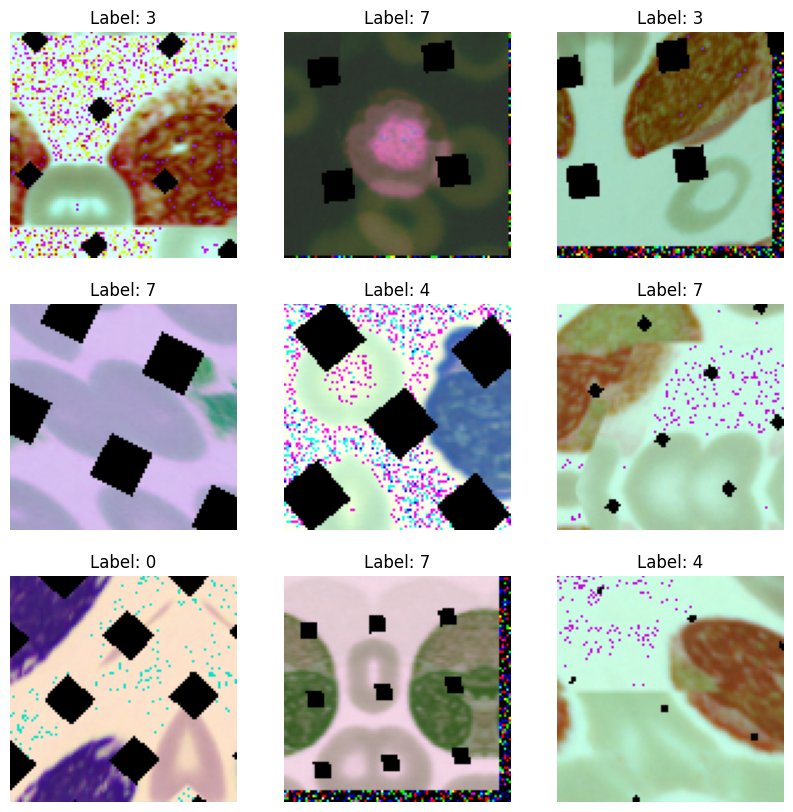

In [ ]:
visualize_dataset(augmented_dataset)

# Create augmented dataset SIZE INCREASE AND RANDOM AUGMENTATIONS

In [ ]:
print(len(training_dataset))

14848


In [ ]:
SIZE_INCREASE = 4

In [ ]:
augmented_dataset = create_augmented_dataset_increase_size(training_dataset, augmentations, SIZE_INCREASE)

Original Dataset Lenght = 14848
Original Dataset Lenght = 14848
Augmented Dataset Lenght = 14848
Original Dataset Lenght = 14848
Augmented Dataset Lenght = 14848
Original Dataset Lenght = 14848
Augmented Dataset Lenght = 14848
Original Dataset Lenght = 14848
Augmented Dataset Lenght = 14848
Original Dataset Lenght = 14848
Augmented Dataset Lenght = 14848
Augmented Dataset Lenght = 89088


In [ ]:
len(augmented_dataset)

89088

In [ ]:
# Shuffle the dataset
augmented_dataset = augmented_dataset.shuffle(buffer_size=len(augmented_dataset), seed=SEED)

In [ ]:
# print(f'Dataset element shape: {next(iter(augmented_dataset))[0].shape}')

# print(f'Dataset element label: {next(iter(augmented_dataset))[1].shape}')

KeyboardInterrupt: 

In [ ]:
# visualize_dataset(augmented_dataset)

# Train Classifier


## Base

In [ ]:
from keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# UNCOMMENT THIS IF YOU WANT TO LOAD AN ALREADY AUGMENTED DATASET
# augmented_dataset = tf.data.Dataset.load('augmented_dataset')

In [ ]:
# Extract images and labels from the modified dataset
augmented_images = []
augmented_labels = []

for img, lbl in augmented_dataset:
    augmented_images.append(img.numpy())  # Convert to numpy array
    augmented_labels.append(lbl.numpy())  # Convert to numpy array

# Convert lists to NumPy arrays
augmented_images_array = np.array(augmented_images)
augmented_labels_array = np.array(augmented_labels)

# Print the shapes of the arrays
print("Augmented Images Shape:", augmented_images_array.shape)
print("Augmented Labels Shape:", augmented_labels_array.shape)

In [ ]:
# Input shape for the model
input_shape = augmented_images_array.shape[1:]

# Output shape for the model
output_shape = augmented_labels_array.shape[-1]

print(input_shape)
print(output_shape)

In [ ]:
model = tfk.applications.ConvNeXtBase(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
    name="convnext_base",
)
# Display a summary of the model architecture
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Training with freezed model

In [ ]:
# Freeze all layers in model to use it solely as a feature extractor
model.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass augmented inputs through the model feature extractor
x = model(inputs)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.2, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(output_shape, activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                 optimizer=tfk.optimizers.AdamW(learning_rate=1e-3),
                 metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Learning Rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * (1-0.01)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x=augmented_images_array,
    y=augmented_labels_array,
    batch_size=64,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
        lr_scheduler
        ]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'ConvBase.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del model
del tl_model

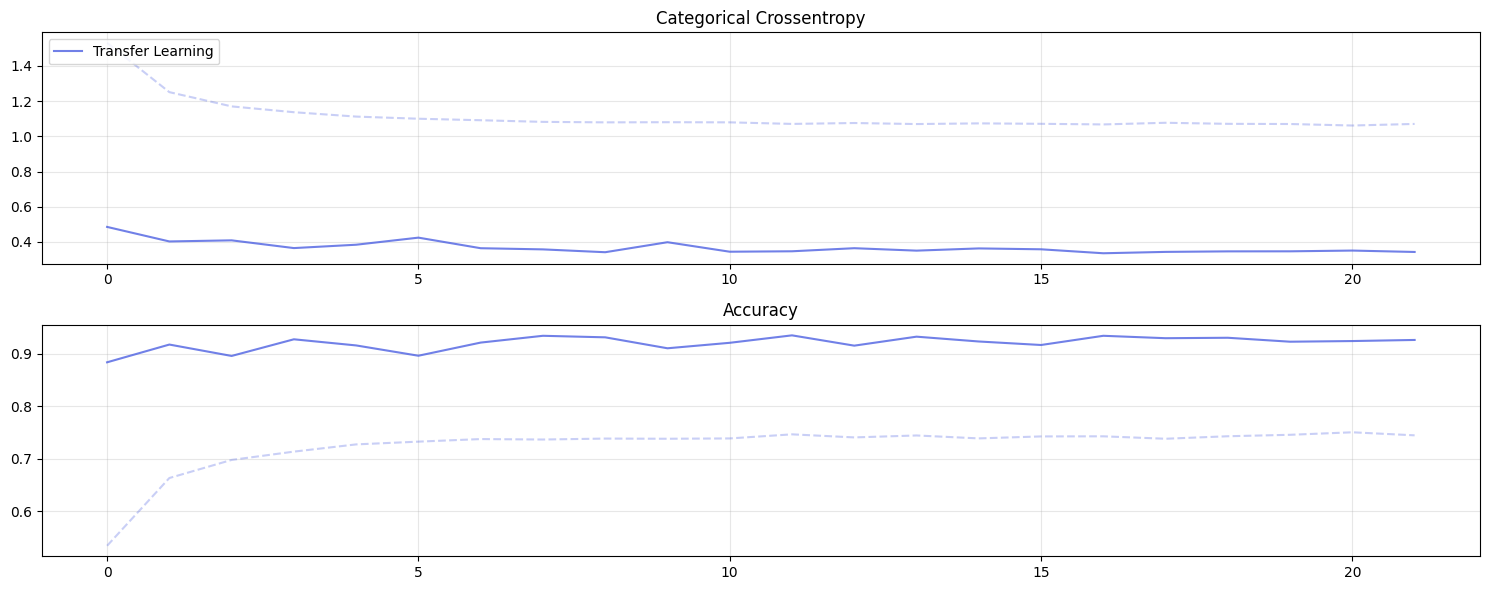

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot loss for both re-trained and transfer learning models
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both re-trained and transfer learning models
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent label overlap and display the plots
plt.tight_layout()
plt.show()

## Fine Tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('ConvBase.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('convnext_base').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('convnext_base').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

3 convnext_base_stage_0_block_0_depthwise_conv Conv2D True
10 convnext_base_stage_0_block_1_depthwise_conv Conv2D True
17 convnext_base_stage_0_block_2_depthwise_conv Conv2D True
25 convnext_base_stage_1_block_0_depthwise_conv Conv2D True
32 convnext_base_stage_1_block_1_depthwise_conv Conv2D True
39 convnext_base_stage_1_block_2_depthwise_conv Conv2D True
47 convnext_base_stage_2_block_0_depthwise_conv Conv2D True
54 convnext_base_stage_2_block_1_depthwise_conv Conv2D True
61 convnext_base_stage_2_block_2_depthwise_conv Conv2D True
68 convnext_base_stage_2_block_3_depthwise_conv Conv2D True
75 convnext_base_stage_2_block_4_depthwise_conv Conv2D True
82 convnext_base_stage_2_block_5_depthwise_conv Conv2D True
89 convnext_base_stage_2_block_6_depthwise_conv Conv2D True
96 convnext_base_stage_2_block_7_depthwise_conv Conv2D True
103 convnext_base_stage_2_block_8_depthwise_conv Conv2D True
110 convnext_base_stage_2_block_9_depthwise_conv Conv2D True
117 convnext_base_stage_2_block_10_dept

In [ ]:
# Set the number of layers to freeze
N = 201

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(1e-4),
                 metrics=['accuracy'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x=augmented_images_array,
    y=augmented_labels_array,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5,
                                             restore_best_weights=True),
        lr_scheduler
        ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'ConvBase_ft'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.9492 - loss: 0.1758 - val_accuracy: 0.9753 - val_loss: 0.0795 - learning_rate: 1.0000e-04
Epoch 2/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.9913 - loss: 0.0376 - val_accuracy: 0.9787 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 3/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.9978 - loss: 0.0147 - val_accuracy: 0.9808 - val_loss: 0.0621 - learning_rate: 1.0000e-04
Epoch 4/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.9989 - loss: 0.0073 - val_accuracy: 0.9803 - val_loss: 0.0607 - learning_rate: 1.0000e-04
Epoch 5/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.9998 - loss: 0.0033 - val_accuracy: 0.9803 - val_loss: 0.0618 - learning_rate: 1.0000e-04
Epoch 6/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9816 - val_loss: 0.0626 - learning_rate: 1.0000e-04
Epoch 7/200
232/232 ━━━━━━━━━━━━━━━━━━━━ 23s 

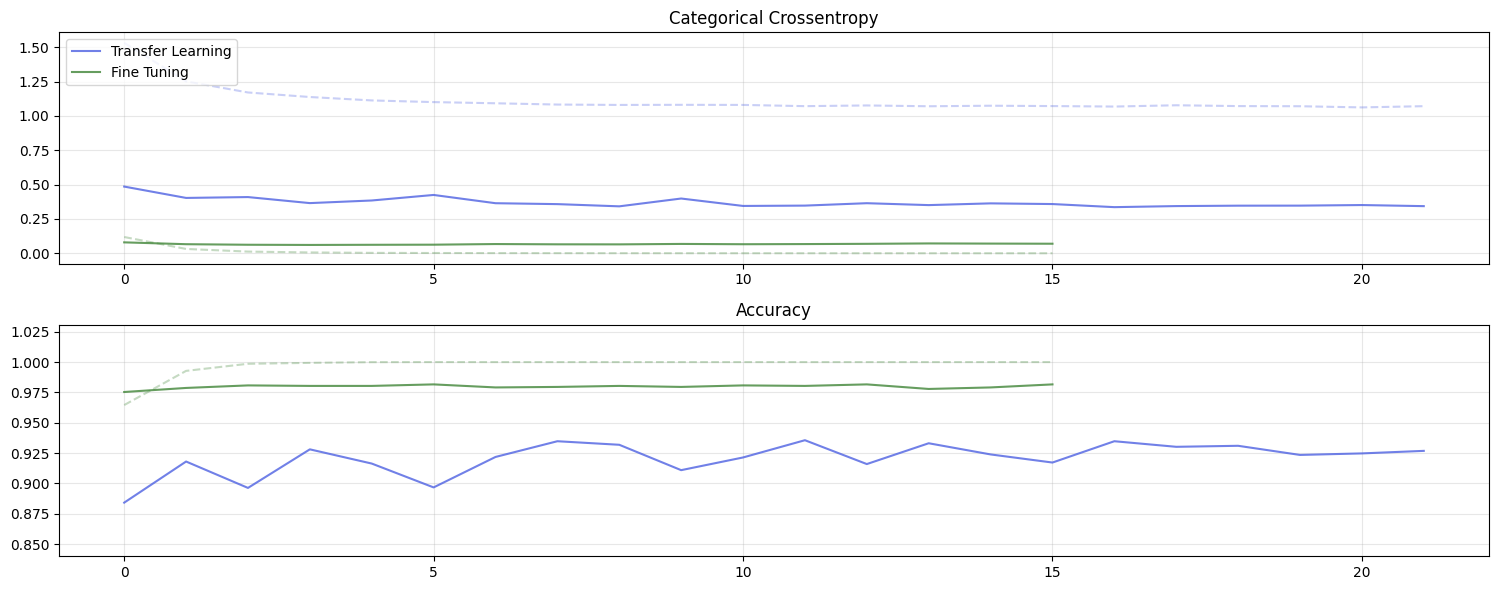

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()